In [20]:
import numpy as np
import pandas as pd
#from scipy.io import loadmat
import matplotlib.pyplot as plt
from preprocessing import NormalScaler
import time

In [29]:
class MLP:

    def __init__(self, layers_arr, activ_arr):
        '''
        This is the constructor for the class MLP.
        The following attributes are initialized in this constructor
        W_list: a list of weight matrices. Each weight matrix 
                connects one layer to the next one.
        b_list: a list of bias weights. Each layer has a bias weight.
        grad_W: list of gradient matrices. Each matrix has gradients 
                of the J wrt weights in the corresponding weight matrix in W_list.
        b_grad: list of gradients of J wrt biases.
        A: a list of vectors. Each vector represents a layer of neurons and their values.
        derr: a list of vectors containing errors generated using backpropogation.
        L: number of layers excluding the input layer
        activ_arr: contains activation function to be used for a particular layer
        '''
        self.W_list = []
        self.b_list = []
        self.grad_W = []
        self.grad_b = []
        self.A = []
        self.derr = []
        self.L = len(layers_arr)-1
        self.activ_arr = activ_arr
        self.n = layers_arr[0]
        for l in range(self.L):
            #self.b_list.append(np.random.randn(1,).astype(np.float64)[0])
            #self.grad_b.append(np.random.randn(1,).astype(np.float64)[0])
            #self.W_list.append(np.random.randn( layers_arr[l+1], layers_arr[l]).astype(np.float64))
            #self.grad_W.append(np.random.randn( layers_arr[l+1], layers_arr[l]).astype(np.float64))
            self.b_list.append(np.random.random(1,).astype(np.float64)[0])
            self.grad_b.append(np.random.random(1,).astype(np.float64)[0])
            self.W_list.append(np.random.randn( layers_arr[l+1], layers_arr[l]).astype(np.float64))
            self.grad_W.append(np.random.randn( layers_arr[l+1], layers_arr[l]).astype(np.float64))
        for l in range(self.L+1):
            self.A.append(np.ndarray(shape=( layers_arr[l], 1 )).astype(np.float64))
            self.derr.append(np.ndarray(shape=( layers_arr[l], 1 )).astype(np.float64))

        # vectorized versions of activation functions
        self.relu_v = np.vectorize(self.relu)
        self.sigmoid_v = np.vectorize(self.sigmoid)

        # arrays for plotting
        self.acc_arr = {'train':[],'test':[]}
        self.cost_arr = {'train':[],'test':[]}
    
    def compute_Z(self, l):
        '''
        This function computes the output of layer of neurons before activation.
        '''
        return np.matmul(self.W_list[l-1], self.A[l-1]) + self.b_list[l-1]

    def activation(self, Z, activ, deriv = 0):
        '''
        This function returns the activated output of a layer of neurons.
        '''
        if(activ=='sigmoid'):
            return self.sigmoid_v(Z, deriv)
        elif(activ=='relu'):
            return self.relu_v(Z, deriv)
        

    def relu(self, x, deriv = 0):
        if deriv==1: 
            return 0 if x<0 else 1 
        return 0 if x<0 else x

    def sigmoid(self, x, deriv = 0):
        if deriv==1:
            return self.sigmoid(x)*(1-self.sigmoid(x))
        return 1/(1+np.exp(-x))
    
    def softmax(self,z,deriv = 0):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T


    def forward_prop(self, X_i):
        '''
        This function takes ith data vector and propogates
        it forward in the neural network.
        '''
        self.A[0] = X_i.reshape(-1,1)
        for l in range(1,self.L+1):
            self.A[l] = self.activation(self.compute_Z(l), self.activ_arr[l-1])
    
    def train(self, X, y, X_test, y_test, alpha, batch_size, max_iter):
        '''
        This function takes the training data and target values,
        applies forward propogation, then applies backward propogation
        to update the weight matrices.
        mini-batch gradient descent has been used to update weights.
        '''
        m = y.shape[0]
        difference = 1000
        iteration = 0
        while(difference>0.0001):
            iteration = iteration + 1
            for i in range(0,m-batch_size+1,batch_size):
                for l in range(self.L): self.grad_b[l]=0
                for l in range(self.L): self.grad_W[l].fill(0)

                for j in range(i,i+batch_size):
                    # forward propogation
                    self.forward_prop(X[j])

                    # Backpropogation of errors
                    self.derr[self.L] = (self.A[self.L]-y[j].reshape(-1,1)) * self.activation(self.compute_Z(self.L), self.activ_arr[self.L-1], 1)
                    for l in range(self.L-1, 0,-1):
                        self.derr[l] = self.activation(self.compute_Z(l), self.activ_arr[l-1], 1)*np.matmul(self.W_list[l].T, self.derr[l+1])
                
                    for l in range(self.L, 0,-1):
                        self.grad_b[l-1] += np.mean(self.derr[l])
                        self.grad_W[l-1] += np.matmul(self.derr[l], self.A[l-1].T)
                
                # weight update after backpropogating each batch
                for l in range(self.L, 0,-1):
                    self.b_list[l-1] -= (alpha/batch_size)*self.grad_b[l-1]
                    self.W_list[l-1] -= (alpha/batch_size)*self.grad_W[l-1]
            
            # if iteration%()==0:
            cost = self.eval_cost(X,y)
            acc = self.accuracy(X,y)
            self.cost_arr['train'].append(cost)
            length = len(self.cost_arr['train'])
            if(length>1):
                difference = self.cost_arr['train'][length-2] - self.cost_arr['train'][length-1]
            #if(cost_arr['tra'])
            self.acc_arr['train'].append(acc)
            test_acc = self.accuracy(X_test,y_test)
            test_cost = self.eval_cost(X_test,y_test)
            self.cost_arr['test'].append(test_cost)
            self.acc_arr['test'].append(test_acc)
            print("iteration: {0} ".format(iteration),end="  ")
            print(" ","Cost : ",cost,end=" ")
            print("  ","Train_acc : ",acc,"  ","Test_acc: ",test_acc)

            # if (test_acc-max(self.acc_arr['test']))<-0.008:
            #     break

    def eval_cost(self, X, y):
        cost = 0

        for i in range(y.shape[0]):
            # forward propogation
            self.forward_prop(X[i])
            cost += np.sum((self.A[self.L]-y[i].reshape(-1,1))**2)
        return cost/(2*X.shape[0])

    def accuracy(self, X, y):
        acc = 0
        for i in range(y.shape[0]):
            # forward propogation
            self.forward_prop(X[i])
            #t1 = np.argmax(self.A[self.L])
            yt = np.argmax(y[i])
            t1 = 0 if self.A[self.L][0][0]<0.5 else 1
            t2 = 0 if self.A[self.L][1][0]<0.5 else 1
            #acc += (t1==yt)
            acc += ((t1==y[i][0]) and (t2==y[i][1]))
        return acc/y.shape[0]

    def conf_mat(self, X, y):
        conf_mat = np.zeros((y.shape[1],y.shape[1]))
        y_p = self.predict(X)
        for i in range(y.shape[0]):
            # forward propogation
            conf_mat[int(np.argmax(y[i]))][int(y_p[i])] += 1
        return conf_mat
    
    def predict(self, X):
        y_pred = np.ndarray(X.shape[0])
        for i in range(X.shape[0]):
            # forward propogation
            self.forward_prop(X[i])
            y_pred[i] = np.argmax(self.A[self.L])
        return y_pred


In [78]:
def start_run(X_train,y_train,X_test,y_test):
    # m = number of feature vectors
    m = X_train.shape[0]
    # n = number of features
    n = X_train.shape[1]
    print(m,n)
    alpha = 0.7
    max_iter = 50

    # number of neurons in each layer
    #Layers = [n,50,2]
    #activations = ['sigmoid','sigmoid','sigmoid']
    Layers = [n,50,25,18,16,4,2]
    activations = ['sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid']
    batch_size = 50

    start_time = time.time()

    model = MLP(Layers, activations)
    model.train(X_train, y_train, X_test, y_test, alpha, batch_size, max_iter)

    end_time = time.time()

    print("Test Accuracy", model.accuracy(X_test,y_test))
    conf = model.conf_mat(X_test,y_test)
    print("Confusion matrix", conf)
    print("F1_Score : ", (conf[0][0]+conf[1][1])/(np.sum(conf)))
    test_acc = model.accuracy(X_test,y_test)
    print("Test accuracy: ", test_acc)

   # with open(f'.log.txt', 'a+') as logfile:
    #    logfile.write(f'\n\nalpha = {alpha} max_iter = {max_iter} batch_size = {batch_size} \n {Layers[1:3]}\n{conf} iter={iterat} \n test_accuracy = {test_acc} \n time taken = {end_time-start_time}')

    # Results Visualization
    plt.figure()
    plt.title(f'Cost Function vs iteration plot {Layers}\n alpha={alpha}')
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.plot(model.cost_arr['train'],c='c',label='training set avg cost')
    plt.plot(model.cost_arr['test'], c='r',label='testing set avg cost')
    plt.legend(loc='upper right')
    #plt.savefig(f".{alpha}_{max_iter}_{batch_size}_{Layers[1:3]}_cost_iter_iter_{iterat}.png")
    plt.show()

    plt.figure()
    plt.title(f"Accuracy vs iteration plot {Layers} \n alpha={alpha}")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.plot(model.acc_arr['train'],c='c',label='training set accuracy')
    plt.plot(model.acc_arr['test'], c='r',label='testing set accuracy')
    plt.legend(loc='upper left')
    #plt.savefig(f".{alpha}_{max_iter}_{batch_size}_{Layers[1:3]}_acc_iter_iter_{iterat}.png")
    plt.show()

    return model

In [79]:
def main():
    df = pd.read_csv(filepath_or_buffer='housepricedata.csv', header=0, sep=',')
    #print(df.head())
    col = df.shape[1]
    df.dropna(how="all", inplace=True)
    #df.tail()
    X = df.iloc[:,0:col-1].values
    Y = df.iloc[:,col-1:col].values
    y_cat = Y
    y_cat = np.zeros((Y.shape[0],2)).astype(np.int)
    for i in range(Y.shape[0]):
        y_cat[i][int(Y[i])] = 1
        
    #print(y_cat)
    #X = X.apply( lambda rec:(rec - rec.mean())/rec.std(), axis =0)
    data_in = df.values
    # data preprocessing
    scaler = NormalScaler()
    for j in range(X.shape[1]):
        scaler.fit(X[:,j])
        X[:,j] = scaler.transform(X[:,j])

    

    #indices1 = list(range(X.shape[0]))
    indices1 = list(range(X.shape[0]))
    #indices1 = np.random.permutation(X.shape[0])
    num_training_instances = int(0.8 * X.shape[0])
    train_indices = indices1[:num_training_instances]
    test_indices = indices1[num_training_instances:]
    X_train = X[train_indices]
    Y_train = y_cat[train_indices]
    X_test = X[test_indices]
    Y_test = y_cat[test_indices]
    model = start_run(X_train,Y_train,X_test,Y_test)

1168 10
iteration: 1     Cost :  0.2501905910077873    Train_acc :  0.1190068493150685    Test_acc:  0.0958904109589041
iteration: 2     Cost :  0.24894134916744606    Train_acc :  0.4922945205479452    Test_acc:  0.4863013698630137
iteration: 3     Cost :  0.24725437375703188    Train_acc :  0.4948630136986301    Test_acc:  0.4863013698630137
iteration: 4     Cost :  0.24487650667824168    Train_acc :  0.4794520547945205    Test_acc:  0.4794520547945205
iteration: 5     Cost :  0.24122240726790264    Train_acc :  0.4871575342465753    Test_acc:  0.4828767123287671
iteration: 6     Cost :  0.23555345763728086    Train_acc :  0.5171232876712328    Test_acc:  0.5102739726027398
iteration: 7     Cost :  0.2272275320671749    Train_acc :  0.5428082191780822    Test_acc:  0.541095890410959
iteration: 8     Cost :  0.21565972344833625    Train_acc :  0.6198630136986302    Test_acc:  0.6061643835616438
iteration: 9     Cost :  0.20076290546658282    Train_acc :  0.788527397260274    Test_acc:

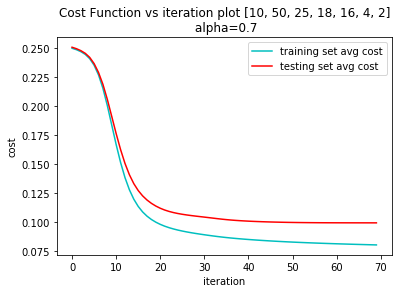

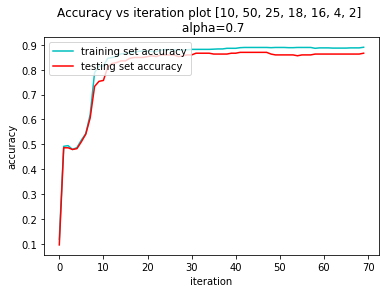

In [80]:
main()